### this script is trying to apply VAE to session-wise functional connectivity patterns

* functional connectivity patterns are derived from AAL atlas with 116 ROIs (with some NAN values)
* for 48 subjects, each 7 sessions by default, with 5 missing sessions
* implemented a fully connected layer + relu network


### main findings so far

* clearly captured individual FC profile in embedding space
* my logic of searching real TMS effect (compared with sham) was to calculate the mean euclidean distance between the null and each sham/real point in embedding space, and compare the difference of the distance
* promising trend: distance between null and real is greater than distance between null and sham
* tried further splitting based on stimloc (aOFC vs pOFC) but did not find differential patterns


In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_rel, wilcoxon

In [2]:
from models import VAE, CVAE # import functions 
from train_utils import train_vae, loss_function
from data_utils import load_all_fc_data, preprocess_for_torch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm # progress bar

In [31]:
from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

In [5]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

In [29]:
sub_cond_path = '/Users/liuq13/NODEAP_scripts/ProcessedData/SubConds.xlsx'
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL'

# Load and preprocess
all_corr_data, all_tms_type, all_subject_id = load_all_fc_data(sub_cond_path, base_nifti_folder)
X_tensor = preprocess_for_torch(all_corr_data)

# Prepare DataLoader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

NUM_EPOCH = 500
LR = 3e-4

[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_30/S3D2/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_44/S1D1/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_83/S3D1/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_87/D0/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_88/D0/conn_matrix.mat
Columns with NaN: 229 / 6670


In [30]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
latent_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=device, epochs=500)

Epoch 1/500: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 81.72it/s]


Epoch 1, Loss: 6808.3892, Recon: 6807.3274, KL: 1.0619


Epoch 2/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 119.60it/s]


Epoch 2, Loss: 6640.3593, Recon: 6637.0474, KL: 3.3118


Epoch 3/500: 100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 95.99it/s]


Epoch 3, Loss: 6514.6648, Recon: 6509.2764, KL: 5.3884


Epoch 4/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.99it/s]


Epoch 4, Loss: 6362.5540, Recon: 6353.3871, KL: 9.1669


Epoch 5/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.22it/s]


Epoch 5, Loss: 6128.8549, Recon: 6112.4835, KL: 16.3715


Epoch 6/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.21it/s]


Epoch 6, Loss: 5876.2694, Recon: 5855.6159, KL: 20.6536


Epoch 7/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.45it/s]


Epoch 7, Loss: 5648.5042, Recon: 5623.0033, KL: 25.5008


Epoch 8/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 141.36it/s]


Epoch 8, Loss: 5424.3347, Recon: 5394.2337, KL: 30.1009


Epoch 9/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 122.84it/s]


Epoch 9, Loss: 5243.0172, Recon: 5210.7837, KL: 32.2335


Epoch 10/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 129.59it/s]


Epoch 10, Loss: 5102.4069, Recon: 5067.2085, KL: 35.1984


Epoch 11/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.28it/s]


Epoch 11, Loss: 4964.5397, Recon: 4926.2916, KL: 38.2480


Epoch 12/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.54it/s]


Epoch 12, Loss: 4848.6524, Recon: 4808.1231, KL: 40.5294


Epoch 13/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 135.68it/s]


Epoch 13, Loss: 4742.5254, Recon: 4699.9617, KL: 42.5636


Epoch 14/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 134.22it/s]


Epoch 14, Loss: 4652.7698, Recon: 4608.1094, KL: 44.6604


Epoch 15/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.30it/s]


Epoch 15, Loss: 4566.2741, Recon: 4519.7186, KL: 46.5556


Epoch 16/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.99it/s]


Epoch 16, Loss: 4486.3436, Recon: 4437.6281, KL: 48.7156


Epoch 17/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 133.03it/s]


Epoch 17, Loss: 4413.5141, Recon: 4363.1771, KL: 50.3371


Epoch 18/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.02it/s]


Epoch 18, Loss: 4345.9619, Recon: 4293.4049, KL: 52.5569


Epoch 19/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.22it/s]


Epoch 19, Loss: 4286.3978, Recon: 4232.0146, KL: 54.3833


Epoch 20/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.18it/s]


Epoch 20, Loss: 4225.0828, Recon: 4168.1681, KL: 56.9147


Epoch 21/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.89it/s]


Epoch 21, Loss: 4163.0503, Recon: 4104.5224, KL: 58.5278


Epoch 22/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 124.29it/s]


Epoch 22, Loss: 4109.9011, Recon: 4050.0493, KL: 59.8518


Epoch 23/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 117.69it/s]


Epoch 23, Loss: 4066.5739, Recon: 4003.4813, KL: 63.0926


Epoch 24/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.02it/s]


Epoch 24, Loss: 4007.7294, Recon: 3943.6793, KL: 64.0502


Epoch 25/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.25it/s]


Epoch 25, Loss: 3957.8469, Recon: 3891.7141, KL: 66.1329


Epoch 26/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 130.35it/s]


Epoch 26, Loss: 3908.6437, Recon: 3840.8093, KL: 67.8343


Epoch 27/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 158.65it/s]


Epoch 27, Loss: 3866.6766, Recon: 3796.6440, KL: 70.0326


Epoch 28/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.51it/s]


Epoch 28, Loss: 3824.0024, Recon: 3752.6401, KL: 71.3623


Epoch 29/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.20it/s]


Epoch 29, Loss: 3787.2391, Recon: 3714.1936, KL: 73.0455


Epoch 30/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.64it/s]


Epoch 30, Loss: 3743.7747, Recon: 3669.2975, KL: 74.4772


Epoch 31/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.40it/s]


Epoch 31, Loss: 3707.4078, Recon: 3631.0386, KL: 76.3692


Epoch 32/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.86it/s]


Epoch 32, Loss: 3675.4937, Recon: 3598.2579, KL: 77.2357


Epoch 33/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.44it/s]


Epoch 33, Loss: 3640.2359, Recon: 3560.7610, KL: 79.4749


Epoch 34/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.91it/s]


Epoch 34, Loss: 3605.5052, Recon: 3525.2438, KL: 80.2614


Epoch 35/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 161.92it/s]


Epoch 35, Loss: 3573.5527, Recon: 3491.8307, KL: 81.7220


Epoch 36/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.19it/s]


Epoch 36, Loss: 3547.7018, Recon: 3464.9876, KL: 82.7142


Epoch 37/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.37it/s]


Epoch 37, Loss: 3518.4647, Recon: 3434.4696, KL: 83.9952


Epoch 38/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.54it/s]


Epoch 38, Loss: 3491.9731, Recon: 3406.6760, KL: 85.2971


Epoch 39/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.00it/s]


Epoch 39, Loss: 3471.0316, Recon: 3385.5909, KL: 85.4407


Epoch 40/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.85it/s]


Epoch 40, Loss: 3446.9195, Recon: 3359.2354, KL: 87.6841


Epoch 41/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.68it/s]


Epoch 41, Loss: 3423.9729, Recon: 3335.6186, KL: 88.3543


Epoch 42/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.99it/s]


Epoch 42, Loss: 3398.7677, Recon: 3309.8015, KL: 88.9662


Epoch 43/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.16it/s]


Epoch 43, Loss: 3380.8782, Recon: 3289.6491, KL: 91.2292


Epoch 44/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.71it/s]


Epoch 44, Loss: 3369.6776, Recon: 3278.5127, KL: 91.1649


Epoch 45/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.78it/s]


Epoch 45, Loss: 3390.7394, Recon: 3298.6732, KL: 92.0662


Epoch 46/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.63it/s]


Epoch 46, Loss: 3327.2226, Recon: 3233.2472, KL: 93.9754


Epoch 47/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.36it/s]


Epoch 47, Loss: 3307.0908, Recon: 3212.7118, KL: 94.3791


Epoch 48/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.68it/s]


Epoch 48, Loss: 3282.8805, Recon: 3187.7861, KL: 95.0944


Epoch 49/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.24it/s]


Epoch 49, Loss: 3262.7464, Recon: 3167.4789, KL: 95.2675


Epoch 50/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.94it/s]


Epoch 50, Loss: 3246.5006, Recon: 3149.7781, KL: 96.7225


Epoch 51/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.45it/s]


Epoch 51, Loss: 3233.3799, Recon: 3136.8538, KL: 96.5261


Epoch 52/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 123.27it/s]


Epoch 52, Loss: 3215.3048, Recon: 3117.4607, KL: 97.8440


Epoch 53/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.90it/s]


Epoch 53, Loss: 3202.2712, Recon: 3104.2791, KL: 97.9921


Epoch 54/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.05it/s]


Epoch 54, Loss: 3182.8874, Recon: 3084.4692, KL: 98.4182


Epoch 55/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.14it/s]


Epoch 55, Loss: 3172.9458, Recon: 3073.5394, KL: 99.4064


Epoch 56/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 132.01it/s]


Epoch 56, Loss: 3162.2529, Recon: 3062.4655, KL: 99.7874


Epoch 57/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.90it/s]


Epoch 57, Loss: 3148.3740, Recon: 3048.1890, KL: 100.1850


Epoch 58/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 133.91it/s]


Epoch 58, Loss: 3138.0290, Recon: 3036.8634, KL: 101.1656


Epoch 59/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 113.81it/s]


Epoch 59, Loss: 3126.6807, Recon: 3025.5049, KL: 101.1758


Epoch 60/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.65it/s]


Epoch 60, Loss: 3118.8072, Recon: 3017.1736, KL: 101.6336


Epoch 61/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 91.81it/s]


Epoch 61, Loss: 3111.5462, Recon: 3009.2995, KL: 102.2466


Epoch 62/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.87it/s]


Epoch 62, Loss: 3092.1211, Recon: 2989.4837, KL: 102.6374


Epoch 63/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.04it/s]


Epoch 63, Loss: 3082.9439, Recon: 2980.0861, KL: 102.8578


Epoch 64/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 127.94it/s]


Epoch 64, Loss: 3070.2671, Recon: 2968.3350, KL: 101.9322


Epoch 65/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.17it/s]


Epoch 65, Loss: 3058.9972, Recon: 2954.4900, KL: 104.5072


Epoch 66/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.73it/s]


Epoch 66, Loss: 3046.8892, Recon: 2943.6334, KL: 103.2558


Epoch 67/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.22it/s]


Epoch 67, Loss: 3034.5522, Recon: 2930.3875, KL: 104.1647


Epoch 68/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.91it/s]


Epoch 68, Loss: 3021.7619, Recon: 2917.7656, KL: 103.9963


Epoch 69/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 161.44it/s]


Epoch 69, Loss: 3009.3819, Recon: 2904.6398, KL: 104.7421


Epoch 70/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 135.85it/s]


Epoch 70, Loss: 3002.0665, Recon: 2897.2722, KL: 104.7943


Epoch 71/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.46it/s]


Epoch 71, Loss: 2993.7326, Recon: 2888.3289, KL: 105.4037


Epoch 72/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.23it/s]


Epoch 72, Loss: 2984.4586, Recon: 2879.8183, KL: 104.6403


Epoch 73/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 160.66it/s]


Epoch 73, Loss: 2975.2935, Recon: 2868.9580, KL: 106.3356


Epoch 74/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.77it/s]


Epoch 74, Loss: 2969.1133, Recon: 2864.1495, KL: 104.9638


Epoch 75/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 161.59it/s]


Epoch 75, Loss: 2959.6047, Recon: 2853.3298, KL: 106.2749


Epoch 76/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.67it/s]


Epoch 76, Loss: 2949.6677, Recon: 2843.6053, KL: 106.0624


Epoch 77/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.01it/s]


Epoch 77, Loss: 2939.8993, Recon: 2834.1102, KL: 105.7891


Epoch 78/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.21it/s]


Epoch 78, Loss: 2933.6227, Recon: 2827.4024, KL: 106.2203


Epoch 79/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 121.96it/s]


Epoch 79, Loss: 2926.9608, Recon: 2820.9462, KL: 106.0145


Epoch 80/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.29it/s]


Epoch 80, Loss: 2917.8483, Recon: 2810.8011, KL: 107.0472


Epoch 81/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 117.43it/s]


Epoch 81, Loss: 2911.0596, Recon: 2804.7034, KL: 106.3562


Epoch 82/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.80it/s]


Epoch 82, Loss: 2904.1528, Recon: 2797.5916, KL: 106.5612


Epoch 83/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.03it/s]


Epoch 83, Loss: 2898.4508, Recon: 2791.3557, KL: 107.0951


Epoch 84/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.71it/s]


Epoch 84, Loss: 2891.3470, Recon: 2784.2291, KL: 107.1179


Epoch 85/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.20it/s]


Epoch 85, Loss: 2884.1093, Recon: 2777.0193, KL: 107.0900


Epoch 86/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.00it/s]


Epoch 86, Loss: 2877.6057, Recon: 2770.2959, KL: 107.3099


Epoch 87/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.09it/s]


Epoch 87, Loss: 2872.3051, Recon: 2764.3995, KL: 107.9056


Epoch 88/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.26it/s]


Epoch 88, Loss: 2867.7725, Recon: 2760.0340, KL: 107.7386


Epoch 89/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.90it/s]


Epoch 89, Loss: 2858.5063, Recon: 2750.4478, KL: 108.0585


Epoch 90/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 141.54it/s]


Epoch 90, Loss: 2854.9698, Recon: 2746.3860, KL: 108.5838


Epoch 91/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.63it/s]


Epoch 91, Loss: 2849.5156, Recon: 2742.1432, KL: 107.3724


Epoch 92/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 163.24it/s]


Epoch 92, Loss: 2841.0421, Recon: 2732.6395, KL: 108.4025


Epoch 93/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.83it/s]


Epoch 93, Loss: 2857.6482, Recon: 2748.9618, KL: 108.6863


Epoch 94/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.84it/s]


Epoch 94, Loss: 2833.5554, Recon: 2724.8059, KL: 108.7496


Epoch 95/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.49it/s]


Epoch 95, Loss: 2825.0269, Recon: 2716.8042, KL: 108.2227


Epoch 96/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 89.47it/s]


Epoch 96, Loss: 2815.5124, Recon: 2706.5113, KL: 109.0011


Epoch 97/500: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 79.61it/s]


Epoch 97, Loss: 2811.5572, Recon: 2702.7680, KL: 108.7892


Epoch 98/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 121.82it/s]


Epoch 98, Loss: 2806.6404, Recon: 2697.7398, KL: 108.9005


Epoch 99/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.39it/s]


Epoch 99, Loss: 2804.5756, Recon: 2696.0431, KL: 108.5326


Epoch 100/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.16it/s]


Epoch 100, Loss: 2797.2669, Recon: 2688.4333, KL: 108.8336


Epoch 101/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 84.11it/s]


Epoch 101, Loss: 2792.0298, Recon: 2683.2386, KL: 108.7913


Epoch 102/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.21it/s]


Epoch 102, Loss: 2787.7766, Recon: 2679.2973, KL: 108.4793


Epoch 103/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.55it/s]


Epoch 103, Loss: 2781.1880, Recon: 2672.2878, KL: 108.9001


Epoch 104/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 130.24it/s]


Epoch 104, Loss: 2776.3959, Recon: 2667.6108, KL: 108.7851


Epoch 105/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 118.43it/s]


Epoch 105, Loss: 2772.4447, Recon: 2663.5688, KL: 108.8759


Epoch 106/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.37it/s]


Epoch 106, Loss: 2769.2604, Recon: 2659.9719, KL: 109.2885


Epoch 107/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 130.52it/s]


Epoch 107, Loss: 2765.3486, Recon: 2655.9359, KL: 109.4127


Epoch 108/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.86it/s]


Epoch 108, Loss: 2758.8624, Recon: 2648.8634, KL: 109.9990


Epoch 109/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.68it/s]


Epoch 109, Loss: 2755.9345, Recon: 2646.6415, KL: 109.2929


Epoch 110/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 86.42it/s]


Epoch 110, Loss: 2750.7691, Recon: 2641.1115, KL: 109.6576


Epoch 111/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.97it/s]


Epoch 111, Loss: 2745.8434, Recon: 2636.0495, KL: 109.7939


Epoch 112/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.68it/s]


Epoch 112, Loss: 2742.4088, Recon: 2633.4387, KL: 108.9701


Epoch 113/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.94it/s]


Epoch 113, Loss: 2735.4631, Recon: 2626.1556, KL: 109.3075


Epoch 114/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 134.76it/s]


Epoch 114, Loss: 2733.6013, Recon: 2623.7446, KL: 109.8568


Epoch 115/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 135.98it/s]


Epoch 115, Loss: 2727.2412, Recon: 2617.6891, KL: 109.5522


Epoch 116/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.38it/s]


Epoch 116, Loss: 2722.6438, Recon: 2612.7989, KL: 109.8448


Epoch 117/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 108.28it/s]


Epoch 117, Loss: 2716.7343, Recon: 2607.4691, KL: 109.2651


Epoch 118/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.93it/s]


Epoch 118, Loss: 2711.8296, Recon: 2602.0769, KL: 109.7528


Epoch 119/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.66it/s]


Epoch 119, Loss: 2707.2732, Recon: 2597.3729, KL: 109.9002


Epoch 120/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.49it/s]


Epoch 120, Loss: 2704.1647, Recon: 2594.7245, KL: 109.4401


Epoch 121/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.20it/s]


Epoch 121, Loss: 2701.1650, Recon: 2591.6242, KL: 109.5408


Epoch 122/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.54it/s]


Epoch 122, Loss: 2693.9361, Recon: 2584.3490, KL: 109.5871


Epoch 123/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 110.65it/s]


Epoch 123, Loss: 2690.3959, Recon: 2580.8553, KL: 109.5407


Epoch 124/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.75it/s]


Epoch 124, Loss: 2688.0793, Recon: 2578.1512, KL: 109.9281


Epoch 125/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 133.85it/s]


Epoch 125, Loss: 2684.7830, Recon: 2574.9910, KL: 109.7921


Epoch 126/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.99it/s]


Epoch 126, Loss: 2676.4401, Recon: 2566.3308, KL: 110.1094


Epoch 127/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.30it/s]


Epoch 127, Loss: 2671.4811, Recon: 2562.0279, KL: 109.4532


Epoch 128/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.57it/s]


Epoch 128, Loss: 2673.3488, Recon: 2562.8359, KL: 110.5130


Epoch 129/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 160.12it/s]


Epoch 129, Loss: 2669.8953, Recon: 2559.5351, KL: 110.3602


Epoch 130/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.70it/s]


Epoch 130, Loss: 2664.8338, Recon: 2554.6979, KL: 110.1359


Epoch 131/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 111.49it/s]


Epoch 131, Loss: 2661.3070, Recon: 2550.9094, KL: 110.3976


Epoch 132/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 68.53it/s]


Epoch 132, Loss: 2660.0219, Recon: 2550.3859, KL: 109.6359


Epoch 133/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 129.54it/s]


Epoch 133, Loss: 2657.3488, Recon: 2547.2178, KL: 110.1310


Epoch 134/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.26it/s]


Epoch 134, Loss: 2651.8535, Recon: 2541.8019, KL: 110.0516


Epoch 135/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 131.60it/s]


Epoch 135, Loss: 2647.9999, Recon: 2537.2538, KL: 110.7461


Epoch 136/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 121.42it/s]


Epoch 136, Loss: 2644.3744, Recon: 2533.8809, KL: 110.4936


Epoch 137/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.15it/s]


Epoch 137, Loss: 2644.3700, Recon: 2534.2114, KL: 110.1586


Epoch 138/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 127.04it/s]


Epoch 138, Loss: 2636.4180, Recon: 2525.8249, KL: 110.5931


Epoch 139/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 135.69it/s]


Epoch 139, Loss: 2630.4690, Recon: 2520.3770, KL: 110.0919


Epoch 140/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.20it/s]


Epoch 140, Loss: 2628.7474, Recon: 2518.2936, KL: 110.4538


Epoch 141/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 141.10it/s]


Epoch 141, Loss: 2624.2377, Recon: 2513.5942, KL: 110.6436


Epoch 142/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.95it/s]


Epoch 142, Loss: 2621.1479, Recon: 2510.5544, KL: 110.5936


Epoch 143/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 141.22it/s]


Epoch 143, Loss: 2618.8614, Recon: 2507.6071, KL: 111.2543


Epoch 144/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 111.31it/s]


Epoch 144, Loss: 2614.9150, Recon: 2503.6816, KL: 111.2335


Epoch 145/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.49it/s]


Epoch 145, Loss: 2607.8317, Recon: 2496.9156, KL: 110.9162


Epoch 146/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.90it/s]


Epoch 146, Loss: 2605.1969, Recon: 2494.3066, KL: 110.8903


Epoch 147/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 54.46it/s]


Epoch 147, Loss: 2602.3493, Recon: 2491.6767, KL: 110.6725


Epoch 148/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 132.19it/s]


Epoch 148, Loss: 2600.5088, Recon: 2489.6678, KL: 110.8410


Epoch 149/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 110.45it/s]


Epoch 149, Loss: 2599.6916, Recon: 2488.7925, KL: 110.8991


Epoch 150/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 107.35it/s]


Epoch 150, Loss: 2597.6603, Recon: 2486.0315, KL: 111.6288


Epoch 151/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 106.92it/s]


Epoch 151, Loss: 2593.1266, Recon: 2482.0087, KL: 111.1179


Epoch 152/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 113.02it/s]


Epoch 152, Loss: 2592.5864, Recon: 2481.1494, KL: 111.4370


Epoch 153/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 125.40it/s]


Epoch 153, Loss: 2588.9004, Recon: 2477.4578, KL: 111.4425


Epoch 154/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.26it/s]


Epoch 154, Loss: 2588.3602, Recon: 2477.3550, KL: 111.0052


Epoch 155/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.00it/s]


Epoch 155, Loss: 2584.6961, Recon: 2473.6906, KL: 111.0056


Epoch 156/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.36it/s]


Epoch 156, Loss: 2579.5892, Recon: 2468.3803, KL: 111.2088


Epoch 157/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.48it/s]


Epoch 157, Loss: 2579.4413, Recon: 2468.2673, KL: 111.1740


Epoch 158/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.33it/s]


Epoch 158, Loss: 2576.5553, Recon: 2464.9798, KL: 111.5754


Epoch 159/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.80it/s]


Epoch 159, Loss: 2575.8349, Recon: 2464.8533, KL: 110.9816


Epoch 160/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.13it/s]


Epoch 160, Loss: 2568.0628, Recon: 2456.1804, KL: 111.8824


Epoch 161/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.24it/s]


Epoch 161, Loss: 2569.7938, Recon: 2456.9196, KL: 112.8742


Epoch 162/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.46it/s]


Epoch 162, Loss: 2566.2083, Recon: 2454.7815, KL: 111.4267


Epoch 163/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 144.23it/s]


Epoch 163, Loss: 2564.0664, Recon: 2451.4455, KL: 112.6208


Epoch 164/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.33it/s]


Epoch 164, Loss: 2559.3760, Recon: 2447.6411, KL: 111.7350


Epoch 165/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.52it/s]


Epoch 165, Loss: 2556.6698, Recon: 2444.2800, KL: 112.3898


Epoch 166/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.22it/s]


Epoch 166, Loss: 2550.7993, Recon: 2439.2615, KL: 111.5378


Epoch 167/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 133.36it/s]


Epoch 167, Loss: 2542.8945, Recon: 2430.3992, KL: 112.4953


Epoch 168/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.51it/s]


Epoch 168, Loss: 2538.2536, Recon: 2426.1654, KL: 112.0882


Epoch 169/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.05it/s]


Epoch 169, Loss: 2534.1347, Recon: 2421.9905, KL: 112.1442


Epoch 170/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.95it/s]


Epoch 170, Loss: 2531.9061, Recon: 2419.6047, KL: 112.3015


Epoch 171/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.51it/s]


Epoch 171, Loss: 2532.1349, Recon: 2420.0753, KL: 112.0597


Epoch 172/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.54it/s]


Epoch 172, Loss: 2530.2126, Recon: 2417.8776, KL: 112.3349


Epoch 173/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.30it/s]


Epoch 173, Loss: 2525.9631, Recon: 2413.2585, KL: 112.7046


Epoch 174/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 127.75it/s]


Epoch 174, Loss: 2519.9976, Recon: 2407.8235, KL: 112.1740


Epoch 175/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.54it/s]


Epoch 175, Loss: 2525.1617, Recon: 2412.8389, KL: 112.3228


Epoch 176/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.92it/s]


Epoch 176, Loss: 2523.0531, Recon: 2410.4060, KL: 112.6471


Epoch 177/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.34it/s]


Epoch 177, Loss: 2516.9626, Recon: 2404.2007, KL: 112.7619


Epoch 178/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.54it/s]


Epoch 178, Loss: 2511.3366, Recon: 2398.8183, KL: 112.5183


Epoch 179/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.80it/s]


Epoch 179, Loss: 2508.4994, Recon: 2395.6715, KL: 112.8279


Epoch 180/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.48it/s]


Epoch 180, Loss: 2504.0891, Recon: 2390.9496, KL: 113.1395


Epoch 181/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.32it/s]


Epoch 181, Loss: 2504.2234, Recon: 2391.4760, KL: 112.7474


Epoch 182/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.61it/s]


Epoch 182, Loss: 2505.1502, Recon: 2392.3234, KL: 112.8267


Epoch 183/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.34it/s]


Epoch 183, Loss: 2499.7794, Recon: 2386.9450, KL: 112.8344


Epoch 184/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 65.33it/s]


Epoch 184, Loss: 2496.5068, Recon: 2383.5536, KL: 112.9532


Epoch 185/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 134.05it/s]


Epoch 185, Loss: 2497.4670, Recon: 2384.9706, KL: 112.4964


Epoch 186/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.51it/s]


Epoch 186, Loss: 2493.9695, Recon: 2380.3470, KL: 113.6225


Epoch 187/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.72it/s]


Epoch 187, Loss: 2489.0109, Recon: 2375.8780, KL: 113.1329


Epoch 188/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 133.36it/s]


Epoch 188, Loss: 2484.8902, Recon: 2372.0013, KL: 112.8889


Epoch 189/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 133.52it/s]


Epoch 189, Loss: 2479.7625, Recon: 2366.4271, KL: 113.3354


Epoch 190/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.73it/s]


Epoch 190, Loss: 2476.3422, Recon: 2362.3935, KL: 113.9487


Epoch 191/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.87it/s]


Epoch 191, Loss: 2475.6281, Recon: 2362.2562, KL: 113.3719


Epoch 192/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 141.75it/s]


Epoch 192, Loss: 2471.9222, Recon: 2358.2382, KL: 113.6841


Epoch 193/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.81it/s]


Epoch 193, Loss: 2470.2184, Recon: 2356.8899, KL: 113.3286


Epoch 194/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.48it/s]


Epoch 194, Loss: 2469.6787, Recon: 2356.0927, KL: 113.5861


Epoch 195/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.61it/s]


Epoch 195, Loss: 2467.7322, Recon: 2354.2487, KL: 113.4835


Epoch 196/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.25it/s]


Epoch 196, Loss: 2464.9738, Recon: 2350.6724, KL: 114.3014


Epoch 197/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.92it/s]


Epoch 197, Loss: 2461.5824, Recon: 2347.8996, KL: 113.6828


Epoch 198/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 158.52it/s]


Epoch 198, Loss: 2454.9407, Recon: 2340.6836, KL: 114.2571


Epoch 199/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.45it/s]


Epoch 199, Loss: 2451.2944, Recon: 2337.6247, KL: 113.6698


Epoch 200/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.30it/s]


Epoch 200, Loss: 2453.7374, Recon: 2339.3336, KL: 114.4038


Epoch 201/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.52it/s]


Epoch 201, Loss: 2452.7896, Recon: 2338.2155, KL: 114.5740


Epoch 202/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.77it/s]


Epoch 202, Loss: 2449.2039, Recon: 2334.7597, KL: 114.4442


Epoch 203/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 114.39it/s]


Epoch 203, Loss: 2444.5019, Recon: 2330.2294, KL: 114.2725


Epoch 204/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 78.08it/s]


Epoch 204, Loss: 2441.8554, Recon: 2327.2977, KL: 114.5578


Epoch 205/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 110.94it/s]


Epoch 205, Loss: 2438.2599, Recon: 2323.3367, KL: 114.9232


Epoch 206/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 124.48it/s]


Epoch 206, Loss: 2434.9463, Recon: 2320.3767, KL: 114.5695


Epoch 207/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 97.81it/s]


Epoch 207, Loss: 2433.1141, Recon: 2318.4165, KL: 114.6976


Epoch 208/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 117.27it/s]


Epoch 208, Loss: 2431.9680, Recon: 2317.5071, KL: 114.4609


Epoch 209/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.89it/s]


Epoch 209, Loss: 2428.5790, Recon: 2313.6092, KL: 114.9698


Epoch 210/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 132.26it/s]


Epoch 210, Loss: 2426.2655, Recon: 2310.8273, KL: 115.4381


Epoch 211/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.16it/s]


Epoch 211, Loss: 2422.3996, Recon: 2306.5070, KL: 115.8926


Epoch 212/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.86it/s]


Epoch 212, Loss: 2426.3843, Recon: 2311.6450, KL: 114.7393


Epoch 213/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.71it/s]


Epoch 213, Loss: 2422.2880, Recon: 2306.9727, KL: 115.3153


Epoch 214/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.66it/s]


Epoch 214, Loss: 2415.5039, Recon: 2300.4517, KL: 115.0522


Epoch 215/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.43it/s]


Epoch 215, Loss: 2411.9708, Recon: 2296.9780, KL: 114.9927


Epoch 216/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.65it/s]


Epoch 216, Loss: 2410.6338, Recon: 2295.1007, KL: 115.5332


Epoch 217/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.26it/s]


Epoch 217, Loss: 2407.7533, Recon: 2292.5043, KL: 115.2490


Epoch 218/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.67it/s]


Epoch 218, Loss: 2405.5800, Recon: 2290.0658, KL: 115.5142


Epoch 219/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.78it/s]


Epoch 219, Loss: 2403.3193, Recon: 2287.4116, KL: 115.9077


Epoch 220/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 110.01it/s]


Epoch 220, Loss: 2401.0167, Recon: 2285.0507, KL: 115.9659


Epoch 221/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 94.41it/s]


Epoch 221, Loss: 2399.7002, Recon: 2283.2539, KL: 116.4463


Epoch 222/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 130.42it/s]


Epoch 222, Loss: 2397.1427, Recon: 2281.6041, KL: 115.5387


Epoch 223/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.64it/s]


Epoch 223, Loss: 2397.0670, Recon: 2281.0265, KL: 116.0405


Epoch 224/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.54it/s]


Epoch 224, Loss: 2393.9219, Recon: 2277.4175, KL: 116.5044


Epoch 225/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.16it/s]


Epoch 225, Loss: 2391.3814, Recon: 2274.9091, KL: 116.4723


Epoch 226/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.78it/s]


Epoch 226, Loss: 2391.8768, Recon: 2275.6284, KL: 116.2485


Epoch 227/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.60it/s]


Epoch 227, Loss: 2393.4942, Recon: 2277.0282, KL: 116.4660


Epoch 228/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.21it/s]


Epoch 228, Loss: 2385.8171, Recon: 2269.0356, KL: 116.7816


Epoch 229/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.71it/s]


Epoch 229, Loss: 2380.3595, Recon: 2264.0720, KL: 116.2875


Epoch 230/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.54it/s]


Epoch 230, Loss: 2380.2572, Recon: 2263.3493, KL: 116.9080


Epoch 231/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.22it/s]


Epoch 231, Loss: 2376.6845, Recon: 2260.0631, KL: 116.6214


Epoch 232/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.17it/s]


Epoch 232, Loss: 2373.5274, Recon: 2256.3201, KL: 117.2073


Epoch 233/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.17it/s]


Epoch 233, Loss: 2371.6771, Recon: 2254.2145, KL: 117.4626


Epoch 234/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.63it/s]


Epoch 234, Loss: 2370.3875, Recon: 2253.7669, KL: 116.6206


Epoch 235/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.75it/s]


Epoch 235, Loss: 2369.3991, Recon: 2251.9065, KL: 117.4926


Epoch 236/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.82it/s]


Epoch 236, Loss: 2365.6532, Recon: 2248.0340, KL: 117.6192


Epoch 237/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.42it/s]


Epoch 237, Loss: 2363.0525, Recon: 2246.1352, KL: 116.9173


Epoch 238/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.55it/s]


Epoch 238, Loss: 2361.2565, Recon: 2244.0972, KL: 117.1593


Epoch 239/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.01it/s]


Epoch 239, Loss: 2358.6386, Recon: 2241.1764, KL: 117.4622


Epoch 240/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.59it/s]


Epoch 240, Loss: 2355.9391, Recon: 2238.2367, KL: 117.7024


Epoch 241/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.48it/s]


Epoch 241, Loss: 2356.9500, Recon: 2239.4223, KL: 117.5278


Epoch 242/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.49it/s]


Epoch 242, Loss: 2351.1672, Recon: 2233.0848, KL: 118.0823


Epoch 243/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.20it/s]


Epoch 243, Loss: 2349.5804, Recon: 2231.8596, KL: 117.7208


Epoch 244/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 118.55it/s]


Epoch 244, Loss: 2345.2850, Recon: 2226.6008, KL: 118.6842


Epoch 245/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.41it/s]


Epoch 245, Loss: 2342.7465, Recon: 2224.4868, KL: 118.2596


Epoch 246/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.45it/s]


Epoch 246, Loss: 2342.2089, Recon: 2224.0779, KL: 118.1310


Epoch 247/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.64it/s]


Epoch 247, Loss: 2338.6516, Recon: 2220.1531, KL: 118.4985


Epoch 248/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.22it/s]


Epoch 248, Loss: 2335.1885, Recon: 2216.8597, KL: 118.3288


Epoch 249/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.60it/s]


Epoch 249, Loss: 2333.4979, Recon: 2215.0865, KL: 118.4113


Epoch 250/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.46it/s]


Epoch 250, Loss: 2331.0058, Recon: 2212.0767, KL: 118.9291


Epoch 251/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.26it/s]


Epoch 251, Loss: 2330.7686, Recon: 2212.5292, KL: 118.2393


Epoch 252/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.45it/s]


Epoch 252, Loss: 2327.4742, Recon: 2208.1796, KL: 119.2947


Epoch 253/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 135.30it/s]


Epoch 253, Loss: 2323.8452, Recon: 2205.3642, KL: 118.4810


Epoch 254/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.19it/s]


Epoch 254, Loss: 2321.5893, Recon: 2202.1769, KL: 119.4124


Epoch 255/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.47it/s]


Epoch 255, Loss: 2321.0510, Recon: 2201.4186, KL: 119.6324


Epoch 256/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 114.45it/s]


Epoch 256, Loss: 2317.6925, Recon: 2198.3196, KL: 119.3729


Epoch 257/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.05it/s]


Epoch 257, Loss: 2316.6498, Recon: 2197.4211, KL: 119.2286


Epoch 258/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.72it/s]


Epoch 258, Loss: 2310.5762, Recon: 2190.8010, KL: 119.7752


Epoch 259/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 110.03it/s]


Epoch 259, Loss: 2313.0036, Recon: 2193.4325, KL: 119.5711


Epoch 260/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 105.96it/s]


Epoch 260, Loss: 2309.5917, Recon: 2189.8857, KL: 119.7060


Epoch 261/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 92.83it/s]


Epoch 261, Loss: 2308.6336, Recon: 2188.5362, KL: 120.0974


Epoch 262/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 100.92it/s]


Epoch 262, Loss: 2307.7943, Recon: 2187.4269, KL: 120.3674


Epoch 263/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.08it/s]


Epoch 263, Loss: 2304.5690, Recon: 2184.1366, KL: 120.4324


Epoch 264/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.93it/s]


Epoch 264, Loss: 2302.8883, Recon: 2182.0992, KL: 120.7891


Epoch 265/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.28it/s]


Epoch 265, Loss: 2299.7234, Recon: 2179.0698, KL: 120.6537


Epoch 266/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 117.58it/s]


Epoch 266, Loss: 2296.1726, Recon: 2175.6151, KL: 120.5576


Epoch 267/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 144.55it/s]


Epoch 267, Loss: 2295.9807, Recon: 2175.2689, KL: 120.7118


Epoch 268/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 115.34it/s]


Epoch 268, Loss: 2297.3513, Recon: 2177.6327, KL: 119.7186


Epoch 269/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 125.28it/s]


Epoch 269, Loss: 2294.2174, Recon: 2172.7264, KL: 121.4910


Epoch 270/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 127.53it/s]


Epoch 270, Loss: 2291.7890, Recon: 2170.3054, KL: 121.4836


Epoch 271/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.94it/s]


Epoch 271, Loss: 2288.0761, Recon: 2166.6042, KL: 121.4719


Epoch 272/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 77.90it/s]


Epoch 272, Loss: 2285.4276, Recon: 2164.2563, KL: 121.1713


Epoch 273/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.78it/s]


Epoch 273, Loss: 2281.8299, Recon: 2160.4253, KL: 121.4046


Epoch 274/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 132.01it/s]


Epoch 274, Loss: 2281.5158, Recon: 2160.1448, KL: 121.3711


Epoch 275/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.20it/s]


Epoch 275, Loss: 2275.3487, Recon: 2152.8970, KL: 122.4516


Epoch 276/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.33it/s]


Epoch 276, Loss: 2271.2389, Recon: 2149.7509, KL: 121.4879


Epoch 277/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.49it/s]


Epoch 277, Loss: 2270.7751, Recon: 2148.4912, KL: 122.2839


Epoch 278/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.47it/s]


Epoch 278, Loss: 2269.9115, Recon: 2148.2466, KL: 121.6649


Epoch 279/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.90it/s]


Epoch 279, Loss: 2267.9182, Recon: 2145.7420, KL: 122.1762


Epoch 280/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.40it/s]


Epoch 280, Loss: 2266.9390, Recon: 2144.4079, KL: 122.5310


Epoch 281/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.81it/s]


Epoch 281, Loss: 2263.7015, Recon: 2141.6394, KL: 122.0621


Epoch 282/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 123.04it/s]


Epoch 282, Loss: 2264.9226, Recon: 2142.6278, KL: 122.2948


Epoch 283/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 97.95it/s]


Epoch 283, Loss: 2261.4324, Recon: 2138.6103, KL: 122.8221


Epoch 284/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 96.61it/s]


Epoch 284, Loss: 2256.9033, Recon: 2134.6034, KL: 122.2998


Epoch 285/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 90.01it/s]


Epoch 285, Loss: 2256.2790, Recon: 2132.9501, KL: 123.3289


Epoch 286/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 101.80it/s]


Epoch 286, Loss: 2254.8598, Recon: 2132.2653, KL: 122.5945


Epoch 287/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 101.72it/s]


Epoch 287, Loss: 2252.6600, Recon: 2129.4659, KL: 123.1940


Epoch 288/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 100.20it/s]


Epoch 288, Loss: 2249.7328, Recon: 2126.2319, KL: 123.5009


Epoch 289/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 96.21it/s]


Epoch 289, Loss: 2247.0090, Recon: 2123.5370, KL: 123.4720


Epoch 290/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 85.31it/s]


Epoch 290, Loss: 2244.7639, Recon: 2121.5918, KL: 123.1721


Epoch 291/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 93.59it/s]


Epoch 291, Loss: 2243.6310, Recon: 2119.6193, KL: 124.0117


Epoch 292/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 113.14it/s]


Epoch 292, Loss: 2242.5946, Recon: 2119.3278, KL: 123.2668


Epoch 293/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 126.60it/s]


Epoch 293, Loss: 2243.0618, Recon: 2119.1398, KL: 123.9220


Epoch 294/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 92.47it/s]


Epoch 294, Loss: 2238.6468, Recon: 2114.0364, KL: 124.6104


Epoch 295/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 129.69it/s]


Epoch 295, Loss: 2235.4575, Recon: 2111.6662, KL: 123.7914


Epoch 296/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.83it/s]


Epoch 296, Loss: 2232.8391, Recon: 2108.4885, KL: 124.3505


Epoch 297/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 135.04it/s]


Epoch 297, Loss: 2233.4254, Recon: 2109.3644, KL: 124.0610


Epoch 298/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 120.44it/s]


Epoch 298, Loss: 2230.6002, Recon: 2105.7337, KL: 124.8665


Epoch 299/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 114.82it/s]


Epoch 299, Loss: 2226.0227, Recon: 2101.4713, KL: 124.5514


Epoch 300/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 125.18it/s]


Epoch 300, Loss: 2227.4494, Recon: 2102.2027, KL: 125.2466


Epoch 301/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.55it/s]


Epoch 301, Loss: 2223.9184, Recon: 2098.6761, KL: 125.2423


Epoch 302/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.82it/s]


Epoch 302, Loss: 2223.9780, Recon: 2099.0488, KL: 124.9292


Epoch 303/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.01it/s]


Epoch 303, Loss: 2220.4744, Recon: 2095.4419, KL: 125.0326


Epoch 304/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.88it/s]


Epoch 304, Loss: 2218.1544, Recon: 2093.2147, KL: 124.9397


Epoch 305/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.83it/s]


Epoch 305, Loss: 2215.6126, Recon: 2089.9066, KL: 125.7060


Epoch 306/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.12it/s]


Epoch 306, Loss: 2212.7173, Recon: 2086.4352, KL: 126.2821


Epoch 307/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.85it/s]


Epoch 307, Loss: 2211.1053, Recon: 2085.0882, KL: 126.0171


Epoch 308/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.36it/s]


Epoch 308, Loss: 2209.8142, Recon: 2083.5140, KL: 126.3002


Epoch 309/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.90it/s]


Epoch 309, Loss: 2206.8214, Recon: 2080.9450, KL: 125.8764


Epoch 310/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 131.47it/s]


Epoch 310, Loss: 2210.9707, Recon: 2084.9501, KL: 126.0206


Epoch 311/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 99.83it/s]


Epoch 311, Loss: 2207.5090, Recon: 2081.2967, KL: 126.2123


Epoch 312/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 110.48it/s]


Epoch 312, Loss: 2204.7948, Recon: 2078.1106, KL: 126.6842


Epoch 313/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 119.09it/s]


Epoch 313, Loss: 2201.5101, Recon: 2074.8091, KL: 126.7010


Epoch 314/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.91it/s]


Epoch 314, Loss: 2202.4977, Recon: 2076.2805, KL: 126.2171


Epoch 315/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.39it/s]


Epoch 315, Loss: 2196.4554, Recon: 2069.8230, KL: 126.6324


Epoch 316/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.91it/s]


Epoch 316, Loss: 2194.2498, Recon: 2066.5736, KL: 127.6762


Epoch 317/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.45it/s]


Epoch 317, Loss: 2193.5131, Recon: 2066.7154, KL: 126.7978


Epoch 318/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 131.17it/s]


Epoch 318, Loss: 2194.0323, Recon: 2066.1554, KL: 127.8769


Epoch 319/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 117.38it/s]


Epoch 319, Loss: 2188.2032, Recon: 2061.2731, KL: 126.9301


Epoch 320/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 113.54it/s]


Epoch 320, Loss: 2193.2511, Recon: 2065.4158, KL: 127.8353


Epoch 321/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 106.38it/s]


Epoch 321, Loss: 2188.4605, Recon: 2060.4585, KL: 128.0020


Epoch 322/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 107.94it/s]


Epoch 322, Loss: 2184.0664, Recon: 2056.7327, KL: 127.3338


Epoch 323/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 117.76it/s]


Epoch 323, Loss: 2178.2101, Recon: 2050.4088, KL: 127.8014


Epoch 324/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 114.80it/s]


Epoch 324, Loss: 2177.2210, Recon: 2049.3041, KL: 127.9170


Epoch 325/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 130.58it/s]


Epoch 325, Loss: 2174.1701, Recon: 2045.7183, KL: 128.4519


Epoch 326/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 111.96it/s]


Epoch 326, Loss: 2172.1366, Recon: 2043.7047, KL: 128.4320


Epoch 327/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 122.76it/s]


Epoch 327, Loss: 2172.5109, Recon: 2044.1930, KL: 128.3179


Epoch 328/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 144.03it/s]


Epoch 328, Loss: 2170.5954, Recon: 2042.2415, KL: 128.3539


Epoch 329/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.49it/s]


Epoch 329, Loss: 2166.5938, Recon: 2037.7999, KL: 128.7939


Epoch 330/500: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 79.35it/s]


Epoch 330, Loss: 2166.3160, Recon: 2037.2857, KL: 129.0303


Epoch 331/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.22it/s]


Epoch 331, Loss: 2163.4112, Recon: 2034.2735, KL: 129.1376


Epoch 332/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 133.42it/s]


Epoch 332, Loss: 2161.9604, Recon: 2032.1736, KL: 129.7868


Epoch 333/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 123.88it/s]


Epoch 333, Loss: 2157.8305, Recon: 2028.9173, KL: 128.9132


Epoch 334/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 108.88it/s]


Epoch 334, Loss: 2156.2352, Recon: 2026.9168, KL: 129.3183


Epoch 335/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 116.28it/s]


Epoch 335, Loss: 2152.4287, Recon: 2023.3105, KL: 129.1182


Epoch 336/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.91it/s]


Epoch 336, Loss: 2154.8246, Recon: 2024.7554, KL: 130.0692


Epoch 337/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.24it/s]


Epoch 337, Loss: 2150.8286, Recon: 2021.1216, KL: 129.7069


Epoch 338/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.75it/s]


Epoch 338, Loss: 2149.3871, Recon: 2019.9011, KL: 129.4860


Epoch 339/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.30it/s]


Epoch 339, Loss: 2144.9948, Recon: 2014.2715, KL: 130.7234


Epoch 340/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.84it/s]


Epoch 340, Loss: 2143.5441, Recon: 2013.0153, KL: 130.5289


Epoch 341/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 135.46it/s]


Epoch 341, Loss: 2140.1481, Recon: 2009.7869, KL: 130.3612


Epoch 342/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.12it/s]


Epoch 342, Loss: 2139.7582, Recon: 2008.1821, KL: 131.5761


Epoch 343/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.46it/s]


Epoch 343, Loss: 2135.8776, Recon: 2005.2924, KL: 130.5852


Epoch 344/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.41it/s]


Epoch 344, Loss: 2133.1593, Recon: 2001.6705, KL: 131.4888


Epoch 345/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.43it/s]


Epoch 345, Loss: 2132.5839, Recon: 2001.3241, KL: 131.2599


Epoch 346/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.22it/s]


Epoch 346, Loss: 2132.2138, Recon: 2001.1607, KL: 131.0531


Epoch 347/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.81it/s]


Epoch 347, Loss: 2131.4756, Recon: 2000.0200, KL: 131.4556


Epoch 348/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.23it/s]


Epoch 348, Loss: 2131.7652, Recon: 2000.3337, KL: 131.4316


Epoch 349/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.27it/s]


Epoch 349, Loss: 2131.5336, Recon: 2000.0597, KL: 131.4739


Epoch 350/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.64it/s]


Epoch 350, Loss: 2128.8249, Recon: 1997.1217, KL: 131.7032


Epoch 351/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.81it/s]


Epoch 351, Loss: 2125.4566, Recon: 1993.1591, KL: 132.2975


Epoch 352/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.10it/s]


Epoch 352, Loss: 2122.7566, Recon: 1991.3676, KL: 131.3890


Epoch 353/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.02it/s]


Epoch 353, Loss: 2119.4370, Recon: 1987.0735, KL: 132.3635


Epoch 354/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 141.77it/s]


Epoch 354, Loss: 2114.9313, Recon: 1982.9733, KL: 131.9581


Epoch 355/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.61it/s]


Epoch 355, Loss: 2117.9487, Recon: 1985.4630, KL: 132.4857


Epoch 356/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 158.73it/s]


Epoch 356, Loss: 2114.1721, Recon: 1980.8170, KL: 133.3550


Epoch 357/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.21it/s]


Epoch 357, Loss: 2107.6250, Recon: 1975.0773, KL: 132.5478


Epoch 358/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.42it/s]


Epoch 358, Loss: 2104.9762, Recon: 1971.8522, KL: 133.1241


Epoch 359/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.65it/s]


Epoch 359, Loss: 2103.3356, Recon: 1969.9990, KL: 133.3366


Epoch 360/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.93it/s]


Epoch 360, Loss: 2105.3522, Recon: 1972.3501, KL: 133.0021


Epoch 361/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.56it/s]


Epoch 361, Loss: 2102.6374, Recon: 1969.2074, KL: 133.4300


Epoch 362/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.54it/s]


Epoch 362, Loss: 2101.3456, Recon: 1968.7046, KL: 132.6409


Epoch 363/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 158.90it/s]


Epoch 363, Loss: 2099.2679, Recon: 1966.1477, KL: 133.1202


Epoch 364/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.71it/s]


Epoch 364, Loss: 2102.5836, Recon: 1968.8070, KL: 133.7766


Epoch 365/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.78it/s]


Epoch 365, Loss: 2097.5782, Recon: 1963.5705, KL: 134.0076


Epoch 366/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.75it/s]


Epoch 366, Loss: 2095.1096, Recon: 1961.2262, KL: 133.8834


Epoch 367/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.24it/s]


Epoch 367, Loss: 2092.3556, Recon: 1958.1791, KL: 134.1765


Epoch 368/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.89it/s]


Epoch 368, Loss: 2091.8975, Recon: 1957.1540, KL: 134.7434


Epoch 369/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.77it/s]


Epoch 369, Loss: 2091.1999, Recon: 1956.7819, KL: 134.4179


Epoch 370/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.31it/s]


Epoch 370, Loss: 2087.4065, Recon: 1952.5164, KL: 134.8901


Epoch 371/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.73it/s]


Epoch 371, Loss: 2084.8260, Recon: 1950.3692, KL: 134.4568


Epoch 372/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 158.11it/s]


Epoch 372, Loss: 2082.9212, Recon: 1948.2537, KL: 134.6674


Epoch 373/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.42it/s]


Epoch 373, Loss: 2078.5386, Recon: 1943.2593, KL: 135.2793


Epoch 374/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 130.74it/s]


Epoch 374, Loss: 2080.7710, Recon: 1945.9670, KL: 134.8040


Epoch 375/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.62it/s]


Epoch 375, Loss: 2077.9907, Recon: 1942.4357, KL: 135.5549


Epoch 376/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.53it/s]


Epoch 376, Loss: 2071.5606, Recon: 1935.7338, KL: 135.8268


Epoch 377/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 128.06it/s]


Epoch 377, Loss: 2071.9259, Recon: 1936.3579, KL: 135.5680


Epoch 378/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.53it/s]


Epoch 378, Loss: 2070.6968, Recon: 1935.1681, KL: 135.5287


Epoch 379/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.25it/s]


Epoch 379, Loss: 2068.9383, Recon: 1933.5478, KL: 135.3904


Epoch 380/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 160.64it/s]


Epoch 380, Loss: 2067.4015, Recon: 1931.7663, KL: 135.6352


Epoch 381/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.93it/s]


Epoch 381, Loss: 2068.4388, Recon: 1932.2908, KL: 136.1480


Epoch 382/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.43it/s]


Epoch 382, Loss: 2064.6620, Recon: 1928.4759, KL: 136.1862


Epoch 383/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.63it/s]


Epoch 383, Loss: 2073.3843, Recon: 1937.0203, KL: 136.3641


Epoch 384/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.53it/s]


Epoch 384, Loss: 2063.2776, Recon: 1926.5352, KL: 136.7424


Epoch 385/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 144.98it/s]


Epoch 385, Loss: 2058.5544, Recon: 1921.4410, KL: 137.1134


Epoch 386/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.92it/s]


Epoch 386, Loss: 2057.6903, Recon: 1921.2207, KL: 136.4696


Epoch 387/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.43it/s]


Epoch 387, Loss: 2056.9851, Recon: 1919.9516, KL: 137.0334


Epoch 388/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.51it/s]


Epoch 388, Loss: 2053.8974, Recon: 1916.5172, KL: 137.3803


Epoch 389/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.34it/s]


Epoch 389, Loss: 2050.9370, Recon: 1913.7275, KL: 137.2095


Epoch 390/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.41it/s]


Epoch 390, Loss: 2047.0242, Recon: 1909.8126, KL: 137.2116


Epoch 391/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.54it/s]


Epoch 391, Loss: 2047.6755, Recon: 1911.0101, KL: 136.6654


Epoch 392/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.70it/s]


Epoch 392, Loss: 2047.4323, Recon: 1909.2833, KL: 138.1491


Epoch 393/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.49it/s]


Epoch 393, Loss: 2041.6217, Recon: 1904.0525, KL: 137.5692


Epoch 394/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.13it/s]


Epoch 394, Loss: 2038.8785, Recon: 1900.8657, KL: 138.0127


Epoch 395/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 139.82it/s]


Epoch 395, Loss: 2039.8171, Recon: 1901.5172, KL: 138.2999


Epoch 396/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.44it/s]


Epoch 396, Loss: 2041.0578, Recon: 1902.8778, KL: 138.1801


Epoch 397/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.11it/s]


Epoch 397, Loss: 2039.4421, Recon: 1900.7066, KL: 138.7355


Epoch 398/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.84it/s]


Epoch 398, Loss: 2035.3796, Recon: 1897.1121, KL: 138.2675


Epoch 399/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.75it/s]


Epoch 399, Loss: 2032.5203, Recon: 1893.8411, KL: 138.6791


Epoch 400/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.63it/s]


Epoch 400, Loss: 2028.1064, Recon: 1889.2418, KL: 138.8646


Epoch 401/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 134.51it/s]


Epoch 401, Loss: 2026.6608, Recon: 1887.5842, KL: 139.0766


Epoch 402/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.24it/s]


Epoch 402, Loss: 2024.3687, Recon: 1884.9688, KL: 139.3999


Epoch 403/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.27it/s]


Epoch 403, Loss: 2023.3930, Recon: 1883.6662, KL: 139.7268


Epoch 404/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.97it/s]


Epoch 404, Loss: 2020.4772, Recon: 1881.4026, KL: 139.0746


Epoch 405/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.67it/s]


Epoch 405, Loss: 2017.7845, Recon: 1878.6236, KL: 139.1610


Epoch 406/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.98it/s]


Epoch 406, Loss: 2018.3904, Recon: 1878.9334, KL: 139.4570


Epoch 407/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.78it/s]


Epoch 407, Loss: 2017.6076, Recon: 1878.6237, KL: 138.9839


Epoch 408/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 146.91it/s]


Epoch 408, Loss: 2016.2808, Recon: 1876.5979, KL: 139.6829


Epoch 409/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.02it/s]


Epoch 409, Loss: 2019.2082, Recon: 1878.6825, KL: 140.5257


Epoch 410/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.31it/s]


Epoch 410, Loss: 2015.8345, Recon: 1876.3826, KL: 139.4519


Epoch 411/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.78it/s]


Epoch 411, Loss: 2009.5345, Recon: 1869.6170, KL: 139.9175


Epoch 412/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.57it/s]


Epoch 412, Loss: 2013.0027, Recon: 1872.3770, KL: 140.6257


Epoch 413/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.86it/s]


Epoch 413, Loss: 2010.5396, Recon: 1870.3421, KL: 140.1975


Epoch 414/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.79it/s]


Epoch 414, Loss: 2005.6997, Recon: 1865.2687, KL: 140.4311


Epoch 415/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.30it/s]


Epoch 415, Loss: 2001.2287, Recon: 1860.7088, KL: 140.5198


Epoch 416/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.35it/s]


Epoch 416, Loss: 1998.3474, Recon: 1857.3096, KL: 141.0377


Epoch 417/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.85it/s]


Epoch 417, Loss: 1999.0942, Recon: 1858.2507, KL: 140.8435


Epoch 418/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 144.18it/s]


Epoch 418, Loss: 1994.3051, Recon: 1852.9449, KL: 141.3601


Epoch 419/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.28it/s]


Epoch 419, Loss: 1992.8331, Recon: 1852.0128, KL: 140.8203


Epoch 420/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 158.33it/s]


Epoch 420, Loss: 1993.7218, Recon: 1852.7634, KL: 140.9583


Epoch 421/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.02it/s]


Epoch 421, Loss: 1993.0845, Recon: 1851.3428, KL: 141.7416


Epoch 422/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.56it/s]


Epoch 422, Loss: 1989.4516, Recon: 1847.6958, KL: 141.7558


Epoch 423/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.75it/s]


Epoch 423, Loss: 1987.5077, Recon: 1846.0579, KL: 141.4498


Epoch 424/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.62it/s]


Epoch 424, Loss: 1984.5087, Recon: 1842.8096, KL: 141.6991


Epoch 425/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.89it/s]


Epoch 425, Loss: 1983.9071, Recon: 1841.8188, KL: 142.0883


Epoch 426/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.66it/s]


Epoch 426, Loss: 1982.3956, Recon: 1839.9548, KL: 142.4407


Epoch 427/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.61it/s]


Epoch 427, Loss: 1980.4273, Recon: 1838.3378, KL: 142.0895


Epoch 428/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 144.13it/s]


Epoch 428, Loss: 1980.9306, Recon: 1838.5842, KL: 142.3464


Epoch 429/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.49it/s]


Epoch 429, Loss: 1978.5600, Recon: 1835.8946, KL: 142.6655


Epoch 430/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.22it/s]


Epoch 430, Loss: 1976.9744, Recon: 1833.9095, KL: 143.0649


Epoch 431/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.20it/s]


Epoch 431, Loss: 1973.6028, Recon: 1831.4536, KL: 142.1492


Epoch 432/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.52it/s]


Epoch 432, Loss: 1971.4109, Recon: 1828.4081, KL: 143.0028


Epoch 433/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 144.35it/s]


Epoch 433, Loss: 1968.8593, Recon: 1825.0775, KL: 143.7818


Epoch 434/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.71it/s]


Epoch 434, Loss: 1969.6429, Recon: 1826.3064, KL: 143.3365


Epoch 435/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.75it/s]


Epoch 435, Loss: 1967.5696, Recon: 1824.5350, KL: 143.0346


Epoch 436/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.75it/s]


Epoch 436, Loss: 1964.4077, Recon: 1820.8376, KL: 143.5702


Epoch 437/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.67it/s]


Epoch 437, Loss: 1963.6183, Recon: 1820.2747, KL: 143.3436


Epoch 438/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.72it/s]


Epoch 438, Loss: 1960.7651, Recon: 1817.1804, KL: 143.5847


Epoch 439/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.91it/s]


Epoch 439, Loss: 1958.4797, Recon: 1815.0584, KL: 143.4214


Epoch 440/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.05it/s]


Epoch 440, Loss: 1957.3862, Recon: 1813.8344, KL: 143.5518


Epoch 441/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 137.35it/s]


Epoch 441, Loss: 1956.5808, Recon: 1812.1787, KL: 144.4022


Epoch 442/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.70it/s]


Epoch 442, Loss: 1952.4707, Recon: 1808.5302, KL: 143.9405


Epoch 443/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.89it/s]


Epoch 443, Loss: 1952.5596, Recon: 1808.1915, KL: 144.3681


Epoch 444/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.18it/s]


Epoch 444, Loss: 1950.9379, Recon: 1806.2684, KL: 144.6695


Epoch 445/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.99it/s]


Epoch 445, Loss: 1949.3393, Recon: 1804.6997, KL: 144.6397


Epoch 446/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.87it/s]


Epoch 446, Loss: 1950.2099, Recon: 1805.4687, KL: 144.7412


Epoch 447/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.58it/s]


Epoch 447, Loss: 1949.8674, Recon: 1805.2993, KL: 144.5681


Epoch 448/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.52it/s]


Epoch 448, Loss: 1944.8285, Recon: 1799.8045, KL: 145.0240


Epoch 449/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.92it/s]


Epoch 449, Loss: 1945.5375, Recon: 1800.3543, KL: 145.1832


Epoch 450/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.32it/s]


Epoch 450, Loss: 1944.6650, Recon: 1799.6186, KL: 145.0465


Epoch 451/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.68it/s]


Epoch 451, Loss: 1942.5703, Recon: 1797.2329, KL: 145.3374


Epoch 452/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.99it/s]


Epoch 452, Loss: 1941.4082, Recon: 1796.1912, KL: 145.2169


Epoch 453/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.38it/s]


Epoch 453, Loss: 1937.3768, Recon: 1791.1415, KL: 146.2353


Epoch 454/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.88it/s]


Epoch 454, Loss: 1937.9259, Recon: 1792.0535, KL: 145.8723


Epoch 455/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.01it/s]


Epoch 455, Loss: 1931.6424, Recon: 1785.6028, KL: 146.0396


Epoch 456/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.88it/s]


Epoch 456, Loss: 1932.9672, Recon: 1787.1475, KL: 145.8197


Epoch 457/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 157.45it/s]


Epoch 457, Loss: 1931.6838, Recon: 1785.2805, KL: 146.4033


Epoch 458/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.44it/s]


Epoch 458, Loss: 1929.3968, Recon: 1783.7593, KL: 145.6375


Epoch 459/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.67it/s]


Epoch 459, Loss: 1924.5965, Recon: 1778.5916, KL: 146.0049


Epoch 460/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 156.87it/s]


Epoch 460, Loss: 1924.8140, Recon: 1778.2261, KL: 146.5879


Epoch 461/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.94it/s]


Epoch 461, Loss: 1926.2891, Recon: 1780.0700, KL: 146.2192


Epoch 462/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 142.31it/s]


Epoch 462, Loss: 1925.5915, Recon: 1778.9255, KL: 146.6660


Epoch 463/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.05it/s]


Epoch 463, Loss: 1922.8120, Recon: 1776.2177, KL: 146.5943


Epoch 464/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.07it/s]


Epoch 464, Loss: 1921.2479, Recon: 1774.7094, KL: 146.5385


Epoch 465/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.07it/s]


Epoch 465, Loss: 1915.2288, Recon: 1767.6482, KL: 147.5806


Epoch 466/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 145.92it/s]


Epoch 466, Loss: 1912.6291, Recon: 1766.0191, KL: 146.6100


Epoch 467/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.55it/s]


Epoch 467, Loss: 1913.1494, Recon: 1766.1210, KL: 147.0284


Epoch 468/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.87it/s]


Epoch 468, Loss: 1914.3709, Recon: 1766.3385, KL: 148.0324


Epoch 469/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.73it/s]


Epoch 469, Loss: 1912.7261, Recon: 1764.8635, KL: 147.8626


Epoch 470/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.29it/s]


Epoch 470, Loss: 1911.8453, Recon: 1764.1656, KL: 147.6797


Epoch 471/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.52it/s]


Epoch 471, Loss: 1911.7185, Recon: 1764.0423, KL: 147.6762


Epoch 472/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.95it/s]


Epoch 472, Loss: 1907.2143, Recon: 1759.6922, KL: 147.5222


Epoch 473/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.24it/s]


Epoch 473, Loss: 1905.5755, Recon: 1757.6846, KL: 147.8908


Epoch 474/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 154.76it/s]


Epoch 474, Loss: 1904.8719, Recon: 1756.9602, KL: 147.9117


Epoch 475/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.29it/s]


Epoch 475, Loss: 1902.7334, Recon: 1754.4109, KL: 148.3225


Epoch 476/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.48it/s]


Epoch 476, Loss: 1902.5571, Recon: 1754.9658, KL: 147.5913


Epoch 477/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 155.20it/s]


Epoch 477, Loss: 1900.6339, Recon: 1752.5223, KL: 148.1116


Epoch 478/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.66it/s]


Epoch 478, Loss: 1897.2501, Recon: 1748.6845, KL: 148.5656


Epoch 479/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 101.20it/s]


Epoch 479, Loss: 1894.1572, Recon: 1745.5217, KL: 148.6354


Epoch 480/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 136.37it/s]


Epoch 480, Loss: 1892.0802, Recon: 1743.4549, KL: 148.6253


Epoch 481/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 138.67it/s]


Epoch 481, Loss: 1890.1463, Recon: 1741.1559, KL: 148.9903


Epoch 482/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.78it/s]


Epoch 482, Loss: 1888.4081, Recon: 1740.0886, KL: 148.3195


Epoch 483/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.01it/s]


Epoch 483, Loss: 1887.2865, Recon: 1738.1729, KL: 149.1136


Epoch 484/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 140.40it/s]


Epoch 484, Loss: 1888.3725, Recon: 1740.1106, KL: 148.2620


Epoch 485/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 131.11it/s]


Epoch 485, Loss: 1887.6561, Recon: 1738.6303, KL: 149.0258


Epoch 486/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 149.02it/s]


Epoch 486, Loss: 1884.6597, Recon: 1735.7679, KL: 148.8917


Epoch 487/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.71it/s]


Epoch 487, Loss: 1879.0285, Recon: 1729.8889, KL: 149.1396


Epoch 488/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 148.62it/s]


Epoch 488, Loss: 1877.9907, Recon: 1727.9985, KL: 149.9922


Epoch 489/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.19it/s]


Epoch 489, Loss: 1875.8194, Recon: 1726.3929, KL: 149.4264


Epoch 490/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 150.74it/s]


Epoch 490, Loss: 1876.3185, Recon: 1726.6561, KL: 149.6624


Epoch 491/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.36it/s]


Epoch 491, Loss: 1874.8517, Recon: 1725.2844, KL: 149.5673


Epoch 492/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.87it/s]


Epoch 492, Loss: 1872.3317, Recon: 1722.1775, KL: 150.1543


Epoch 493/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.02it/s]


Epoch 493, Loss: 1871.5006, Recon: 1722.0691, KL: 149.4315


Epoch 494/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 143.27it/s]


Epoch 494, Loss: 1870.3788, Recon: 1720.2854, KL: 150.0934


Epoch 495/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.31it/s]


Epoch 495, Loss: 1870.2188, Recon: 1720.0925, KL: 150.1263


Epoch 496/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.75it/s]


Epoch 496, Loss: 1869.6122, Recon: 1718.9948, KL: 150.6175


Epoch 497/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 151.26it/s]


Epoch 497, Loss: 1867.6405, Recon: 1718.0169, KL: 149.6236


Epoch 498/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 159.37it/s]


Epoch 498, Loss: 1866.0377, Recon: 1715.6786, KL: 150.3591


Epoch 499/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 153.82it/s]


Epoch 499, Loss: 1860.9851, Recon: 1710.1101, KL: 150.8750


Epoch 500/500: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 152.11it/s]

Epoch 500, Loss: 1859.1285, Recon: 1708.6863, KL: 150.4423


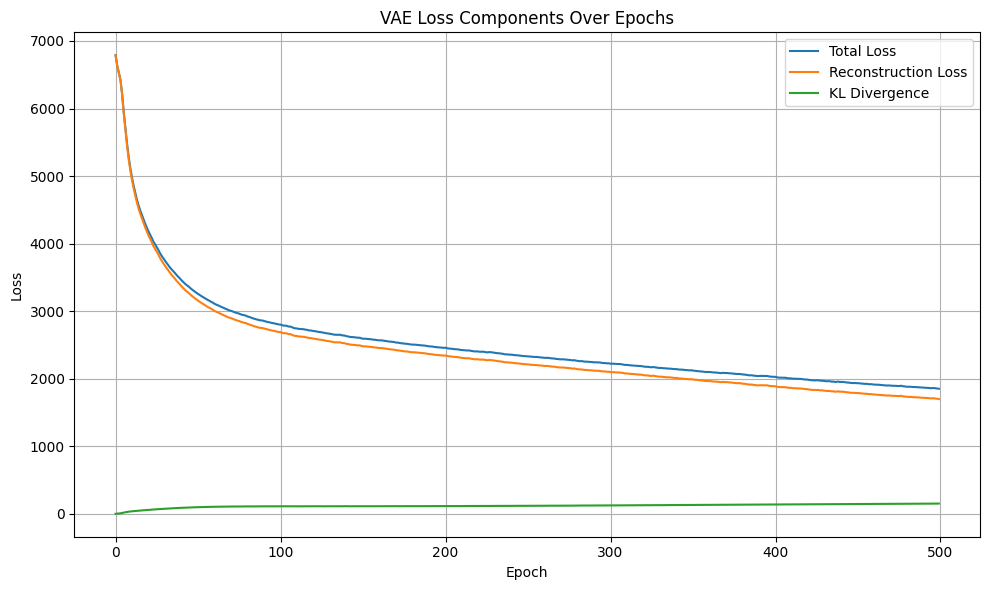

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(total_loss_hist, label='Total Loss')
plt.plot(recon_loss_hist, label='Reconstruction Loss')
plt.plot(kld_loss_hist, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
model.eval()
with torch.no_grad():
    mu_all = []
    for i in range(X_tensor.shape[0]):
        x = torch.tensor(X_tensor[i], dtype=torch.float32).to(device).unsqueeze(0)
        mu, _ = model.encode(x)
        mu_all.append(mu.cpu().numpy().flatten())
mu_all = np.array(mu_all)
print('dim of latent mu:', mu_all.shape)

dim of latent mu: (331, 10)


/var/folders/br/nr4k1vxj1_j7jxk17x7xr8n9g2q0k8/T/ipykernel_90928/2362508139.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_tensor[i], dtype=torch.float32).to(device).unsqueeze(0)


In [24]:
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)

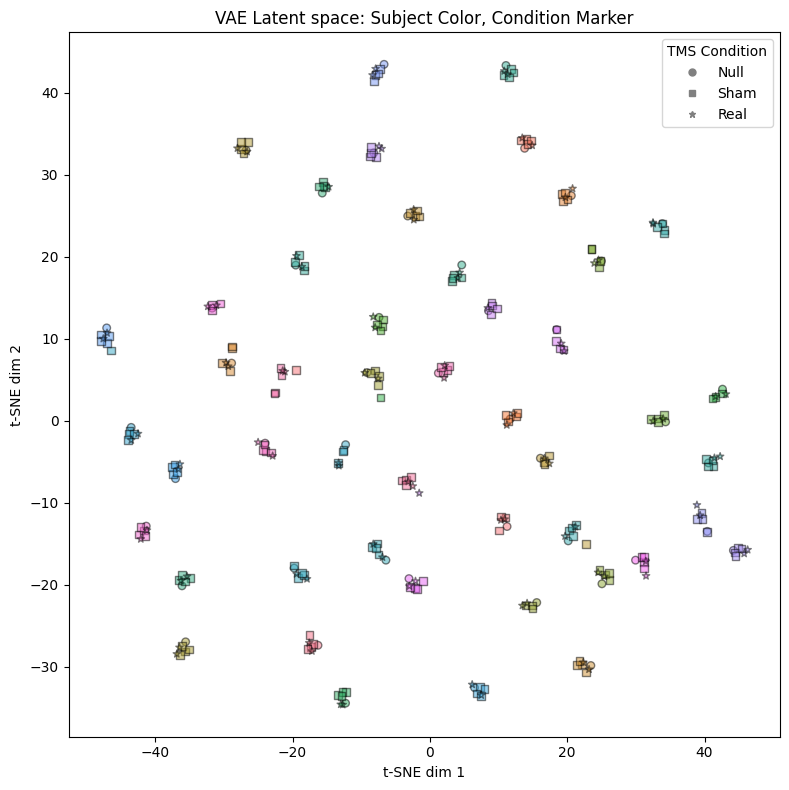

In [25]:
# Map 'N' = 0 (Null), 'S' = 1 (Sham), 'C' = 2 (Real/cTBS)
label_map = {'N': 0, 'S': 1, 'C': 2}
y = np.array([label_map[t] for t in all_tms_type])
y = np.array(y).flatten()
unique_conds = np.unique(y)
markers = ['o', 's', '*']
cond_to_marker = {cond: markers[i] for i, cond in enumerate(unique_conds)}

subject_array = np.array(all_subject_id)
unique_subjects = np.unique(subject_array)
subject_to_idx = {subj: i for i, subj in enumerate(unique_subjects)}
subject_idx = np.array([subject_to_idx[subj] for subj in subject_array])

palette = sns.color_palette("husl", len(unique_subjects))  # 48 distinct hues
subject_colors = np.array([palette[i] for i in subject_idx])

# Plot each condition group with its marker and subject-based color
fig, ax = plt.subplots(figsize=(8, 8))

for cond in unique_conds:
    mask = y == cond
    ax.scatter(
        z_2d[mask, 0],
        z_2d[mask, 1],
        marker=cond_to_marker[cond],
        s=30, # marker size
        c=subject_colors[mask],
        label=f'Condition {cond}',
        edgecolors='k',
        alpha=0.5
    )
handles = [plt.Line2D([0], [0], marker=cond_to_marker[c], color='gray', linestyle='',
                      label={0: 'Null', 1: 'Sham', 2: 'Real'}[c],
                      markersize=5) for c in unique_conds]
ax.legend(handles=handles, title='TMS Condition', loc='upper right')

ax.set_title("VAE Latent space: Subject Color, Condition Marker")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

In [26]:
# Create stimloc mapping
stimloc_map = SubInfo.set_index('SubID')['StimLoc'].to_dict()
stimloc_array = np.array([stimloc_map[subj] for subj in subject_array])

# Split by stimloc
fig, axes = plt.subplots(2, 1, figsize=(7, 14), sharex=True, sharey=True)
stimlocs = ['Anterior', 'Posterior']

for i, loc in enumerate(stimlocs):
    ax = axes[i]
    ax.set_title(f"StimLoc: {loc}")

    for cond in unique_conds:
        mask = (y == cond) & (stimloc_array == loc)
        ax.scatter(
            z_2d[mask, 0],
            z_2d[mask, 1],
            marker=cond_to_marker[cond],
            s=30,
            c=subject_colors[mask],
            label=f'Condition {cond}',
            edgecolors='k',
            alpha=0.5
        )

    handles = [plt.Line2D([0], [0], marker=cond_to_marker[c], color='gray', linestyle='',
                          label={0: 'Null', 1: 'Sham', 2: 'Real'}[c],
                          markersize=5) for c in unique_conds]
    ax.legend(handles=handles, title='TMS Condition', loc='upper right')
    ax.set_xlabel("t-SNE dim 1")
    ax.set_ylabel("t-SNE dim 2")

fig.suptitle("VAE Latent space split by StimLoc", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'SubInfo' is not defined

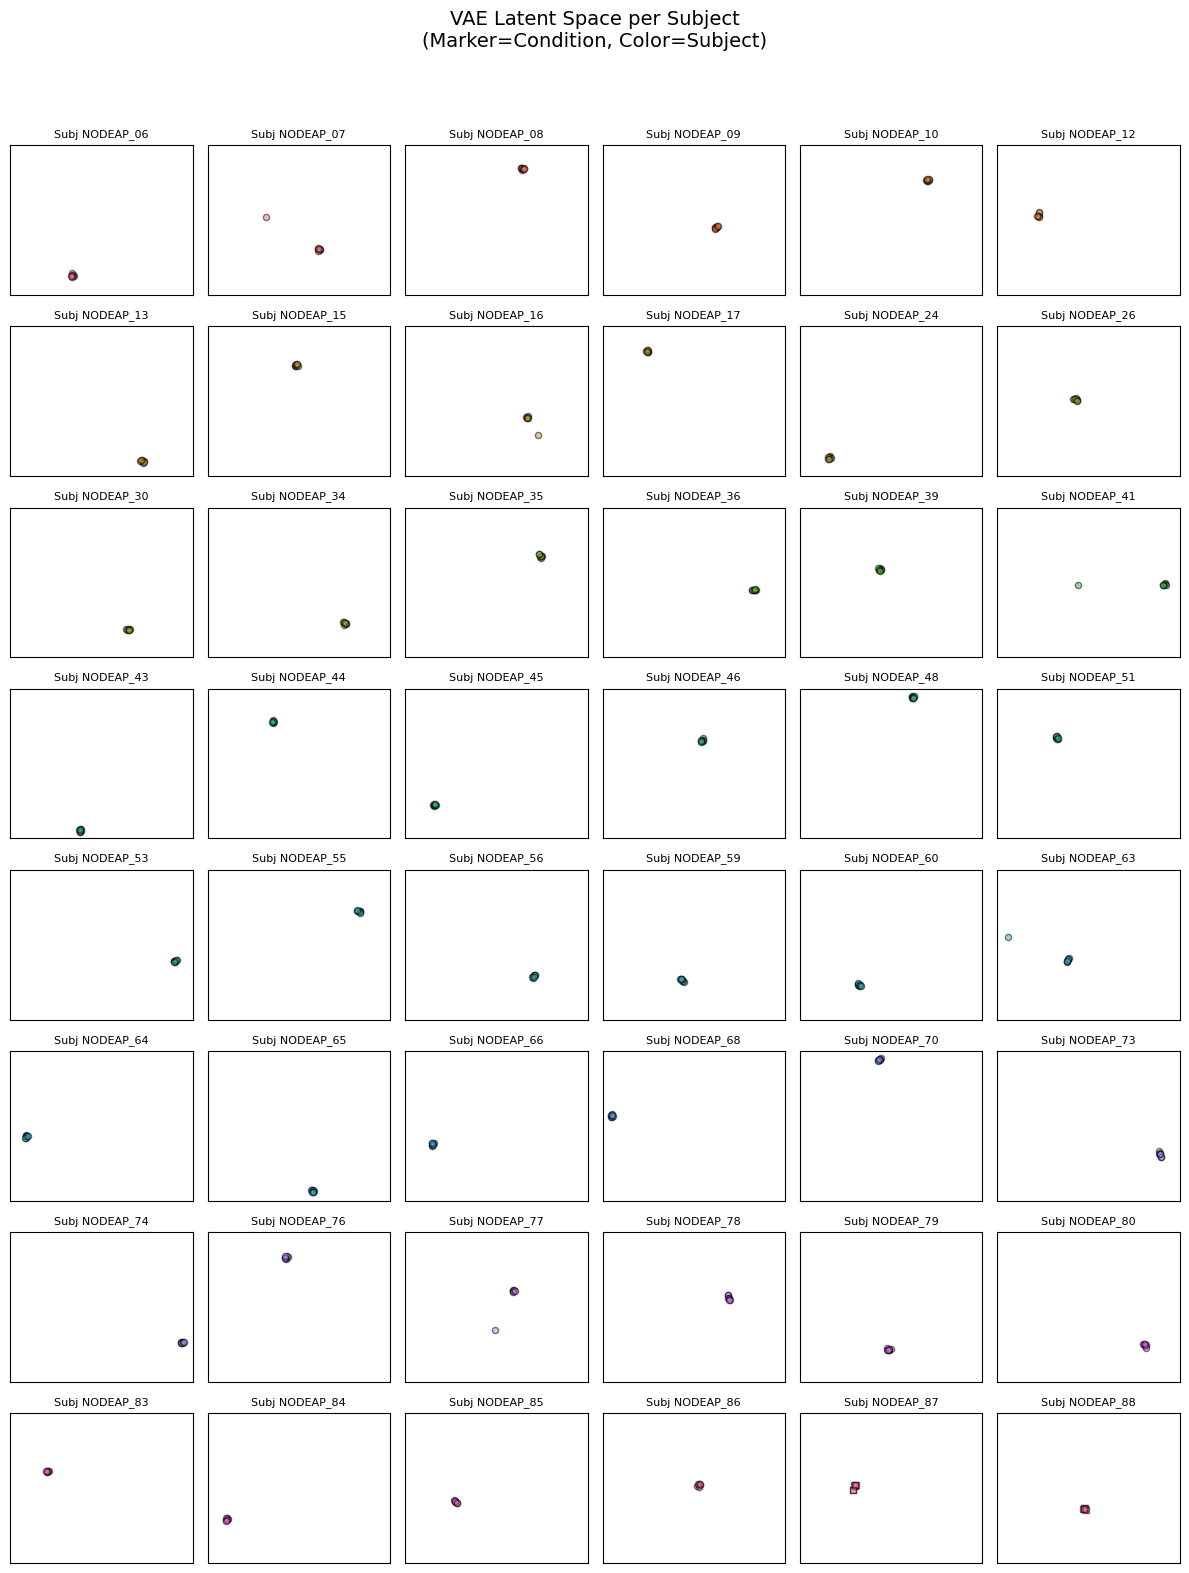

In [27]:
n_subjects = len(unique_subjects)
n_cols = 6
n_rows = int(np.ceil(n_subjects / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), sharex=True, sharey=True)
axs = axs.flatten()

for i, subj in enumerate(unique_subjects):
    ax = axs[i]
    subj_mask = subject_array == subj
    cond = y[subj_mask][0]  # assumes one condition per subject
    marker = cond_to_marker[cond]
    color = palette[subject_to_idx[subj]]

    ax.scatter(
        z_2d[subj_mask, 0],
        z_2d[subj_mask, 1],
        marker=marker,
        s=20,
        c=[color],
        edgecolors='k',
        alpha=0.5
    )
    ax.set_title(f'Subj {subj}', fontsize=8)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("VAE Latent Space per Subject\n(Marker=Condition, Color=Subject)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [28]:
# Prepare your data
mu = np.array(mu_all)  # 331×10 latent variables
y = np.array([label_map[t] for t in all_tms_type])
subject_array = np.array(all_subject_id)
unique_subjects = np.unique(subject_array)

# Store per-subject distances
results = []

for subj in unique_subjects:
    # Indices for this subject
    idx = subject_array == subj
    
    mu_subj = mu[idx]
    y_subj = y[idx]
    
    # Compute mean latent vectors for each condition (0, 1, 2)
    means = {}
    for cond in [0, 1, 2]:
        cond_mu = mu_subj[y_subj == cond]
        if len(cond_mu) > 0:
            means[cond] = np.mean(cond_mu, axis=0)
    
    # Only compute distances if all three conditions are present
    if all(c in means for c in [0, 1, 2]):
        d_0_1 = euclidean(means[0], means[1])
        d_0_2 = euclidean(means[0], means[2])
        results.append({
            "subject": subj,
            "stimloc": stimloc_map[subj],
            "d_null_sham": d_0_1,
            "d_null_real": d_0_2,
            "diff_real_minus_sham": d_0_2 - d_0_1
        })

# Convert to DataFrame
df = pd.DataFrame(results)

NameError: name 'stimloc_map' is not defined

In [ ]:
print(df)

In [ ]:
# Print summary
print(df.describe())

In [ ]:
# Melt the dataframe to long format for seaborn
df_long = pd.melt(
    df,
    id_vars=["subject", "stimloc"],
    value_vars=["d_null_sham", "d_null_real"],
    var_name="Comparison",
    value_name="Distance"
)

# Rename for better display
df_long["Comparison"] = df_long["Comparison"].replace({
    "d_null_sham": "Null vs Sham",
    "d_null_real": "Null vs Real"
})
df_long

In [ ]:
df_long.groupby(['stimloc', 'Comparison'])['Distance'].mean()

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_long, x="Comparison", y="Distance", color="lightgray", showfliers=False)

# Overlay subject-level paired lines
for subj in df["subject"]:
    subj_data = df_long[df_long["subject"] == subj]
    plt.plot(
        subj_data["Comparison"],
        subj_data["Distance"],
        marker='o',
        linestyle='-',
        alpha=0.6,
        color='blue'
    )

plt.title("Paired Distance Comparison per Subject")
plt.ylabel("Euclidean Distance")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")

# Optional: Non-parametric Wilcoxon signed-rank test
try:
    stat_w, p_val_w = wilcoxon(df["d_null_sham"], df["d_null_real"])
    print(f"Wilcoxon signed-rank test: W = {stat_w:.3f}, p = {p_val_w:.4f}")
except ValueError as e:
    print("Wilcoxon test error:", e)


### if separating anterior and posterior group

In [ ]:
stimlocs = ['Anterior', 'Posterior']
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, loc in enumerate(stimlocs):
    ax = axes[i]
    df_loc = df_long[df_long["stimloc"] == loc]
    
    # Draw boxplot
    sns.boxplot(data=df_loc, x="Comparison", y="Distance", color="lightgray", showfliers=False, ax=ax)

    # Draw lines for each subject
    for subj in df_loc["subject"].unique():
        subj_data = df_loc[df_loc["subject"] == subj]
        ax.plot(
            subj_data["Comparison"],
            subj_data["Distance"],
            marker='o',
            linestyle='-',
            alpha=0.6,
            color='blue'
        )

    ax.set_title(f"{loc} Subjects")
    ax.set_xlabel("")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[0].set_ylabel("Euclidean Distance")
plt.suptitle("Paired Distance Comparison per Subject by StimLoc", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
for loc in ['Anterior', 'Posterior']:
    df_loc = df[df['stimloc'] == loc]
    
    print(f"\n--- {loc} ---")
    
    # Paired t-test
    t_stat, p_val_t = ttest_rel(df_loc["d_null_sham"], df_loc["d_null_real"])
    print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
    
    # Wilcoxon signed-rank test
    try:
        stat_w, p_val_w = wilcoxon(df_loc["d_null_sham"], df_loc["d_null_real"])
        print(f"Wilcoxon signed-rank test: W = {stat_w:.3f}, p = {p_val_w:.4f}")
    except ValueError as e:
        print("Wilcoxon test error:", e)
